In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import cftime

### 123 kgN fertilizer experiment

In [36]:
fert_amount = "123"

case_clarion = "MESOCOSM_Clarion_" + fert_amount + "kgN"
case_webster = "MESOCOSM_Webster_" + fert_amount + "kgN"
path_clarion = "/glade/scratch/jinmuluo/archive/" + case_clarion + "/lnd/hist/" 
path_webster = "/glade/scratch/jinmuluo/archive/" + case_webster + "/lnd/hist/" 
start_date = date(2022, 1, 1)
end_date = date(2023, 1, 1)
NO_LEAP = True
delta_days = (end_date - start_date).days

NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 
          'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
          'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", 
         "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]
Others = ["FAN_TOTN", "NITRATE_TOTN",'SMINN', 'SMINN_vr', 'SMIN_NH4_vr', 'SMIN_NO3_vr', 'QOVER', 'H2OSOI', 'TSOI_10CM',
         'SMINN_TO_PLANT_FUN_NO3', 'SMINN_TO_PLANT_FUN_NH4', 'F_NIT', 'F_DENIT']

CLM_Clarion = []
CLM_Webster = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate +"-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate +"-00000.nc")

In [37]:
def preprocess(ds, fields= GAS + Others + RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)

def preprocess(ds, fields=GAS+Others+RUNOFF):
    return(ds[fields])

dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)

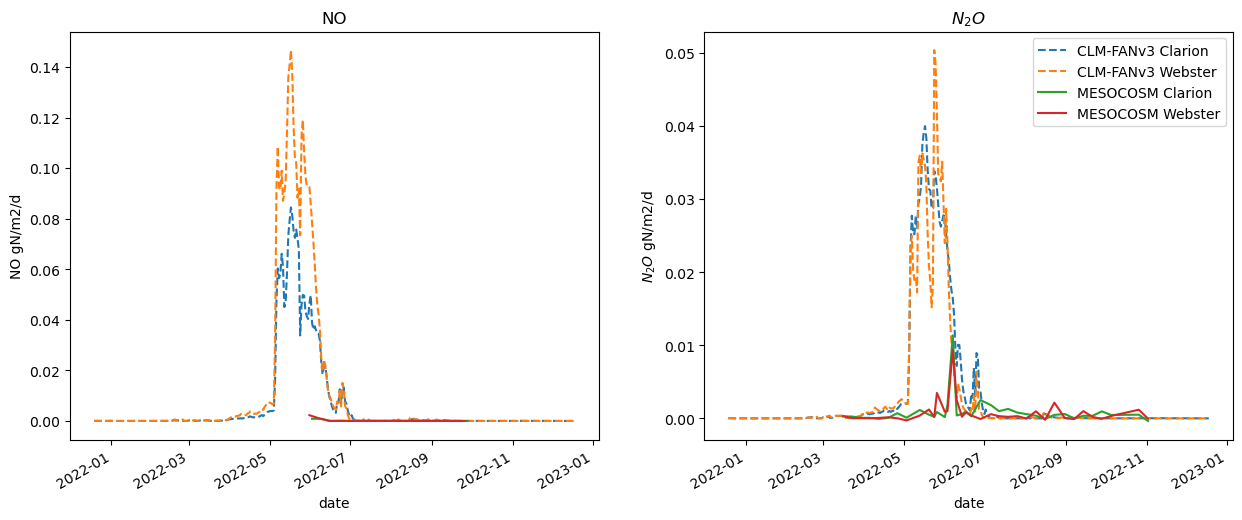

In [38]:
p2 = "/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'mesocosm_ghg_flux_data_2022.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO_Webster.time]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
NO_Clarion.plot(ax=ax[0], ls= '--', label='CLM-FANv3 Clarion')
NO_Webster.plot(ax=ax[0], ls= '--', label='CLM-FANv3 Webster')
dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean().plot(ax=ax[0], label='MESOCOSM Clarion')
dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean().plot(ax=ax[0], label='MESOCOSM Webster')


ax[0].set_title("NO")
ax[0].set_ylabel("NO gN/m2/d")

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in N2O_Webster.time]

N2O_Clarion.plot(ax=ax[1], ls= '--', label='CLM-FANv3 Clarion')
N2O_Webster.plot(ax=ax[1], ls= '--', label='CLM-FANv3 Webster')
dsN2O.loc[('Clarion', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean().plot(ax=ax[1], label='MESOCOSM Clarion')
dsN2O.loc[('Webster', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean().plot(ax=ax[1], label='MESOCOSM Webster')

ax[1].set_title("$N_2O$")
ax[1].set_ylabel("$N_2O$ gN/m2/d")
ax[1].legend()

fig.savefig("graphs/Ngas_123kgN.jpg", dpi=200)
plt.show()

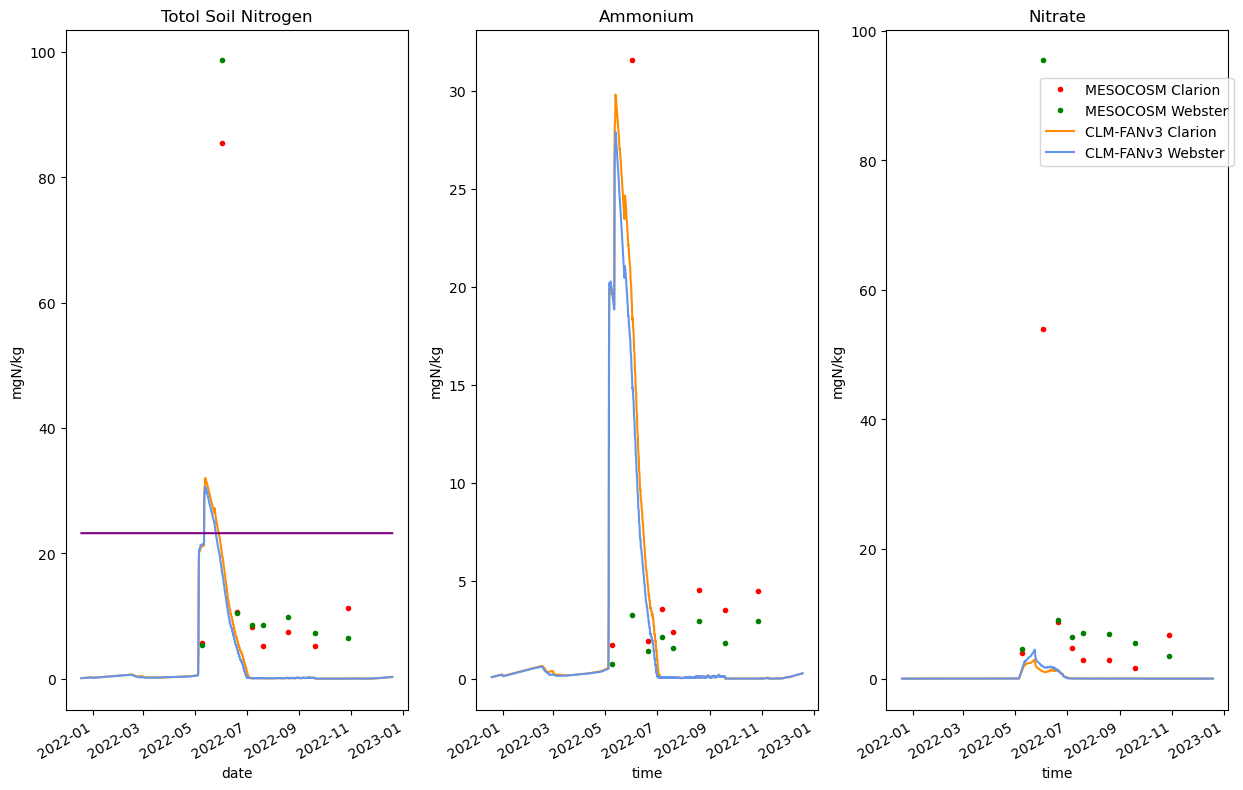

In [39]:
dsMESOCOSM = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mescocosm_extracted_soil_nitrogen_2022.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

dsCLM_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in dsCLM_Clarion.time]
dsCLM_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in dsCLM_Webster.time]

sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
sminn_Clarion = sminn_Clarion*1000/2650
sminn_Webster = sminn_Webster*1000/2650

# gN/m2 to mgN/kg, fertilization depth is around top 20cm
fert_conc = 12.3*1000/0.2/2650
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sminn_Clarion.plot(ax=ax[0], label='CLM-FANv3 Clarion', color='darkorange')
sminn_Webster.plot(ax=ax[0], label='CLM-FANv3 Webster', color='cornflowerblue')
dsMESOCOSM.loc[('Clarion', 123), 'soil_sminn'].groupby(level='date').mean().plot(ax=ax[0], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 123), 'soil_sminn'].groupby(level='date').mean().plot(ax=ax[0], style='.', label='MESOCOSM Webster', color='green')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc, color='purple')
ax[0].set_title("Totol Soil Nitrogen")
ax[0].set_ylabel("mgN/kg")

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
nh4_Clarion = nh4_Clarion*1000/2650
nh4_Webster = nh4_Webster*1000/2650

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
    
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/2650
no3_Webster = no3_Webster*1000/2650

dsMESOCOSM.loc[('Clarion', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean().plot(ax=ax[1], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean().plot(ax=ax[1], style='.', label='MESOCOSM Webster', color='green')
nh4_Clarion.plot(ax=ax[1], label='CLM-FANv3 Clarion', color='darkorange')
nh4_Webster.plot(ax=ax[1], label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].set_title("Ammonium")
ax[1].set_ylabel("mgN/kg")

dsMESOCOSM.loc[('Clarion', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean().plot(ax=ax[2], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean().plot(ax=ax[2], style='.', label='MESOCOSM Webster', color='green')
no3_Clarion.plot(ax=ax[2], label='CLM-FANv3 Clarion', color='darkorange')
no3_Webster.plot(ax=ax[2], label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].set_title("Nitrate")
ax[2].set_ylabel("mgN/kg")

plt.legend(loc=[0.45, 0.80])
fig.savefig("graphs/Nconc_123kgN.jpg", dpi=200)
plt.show()

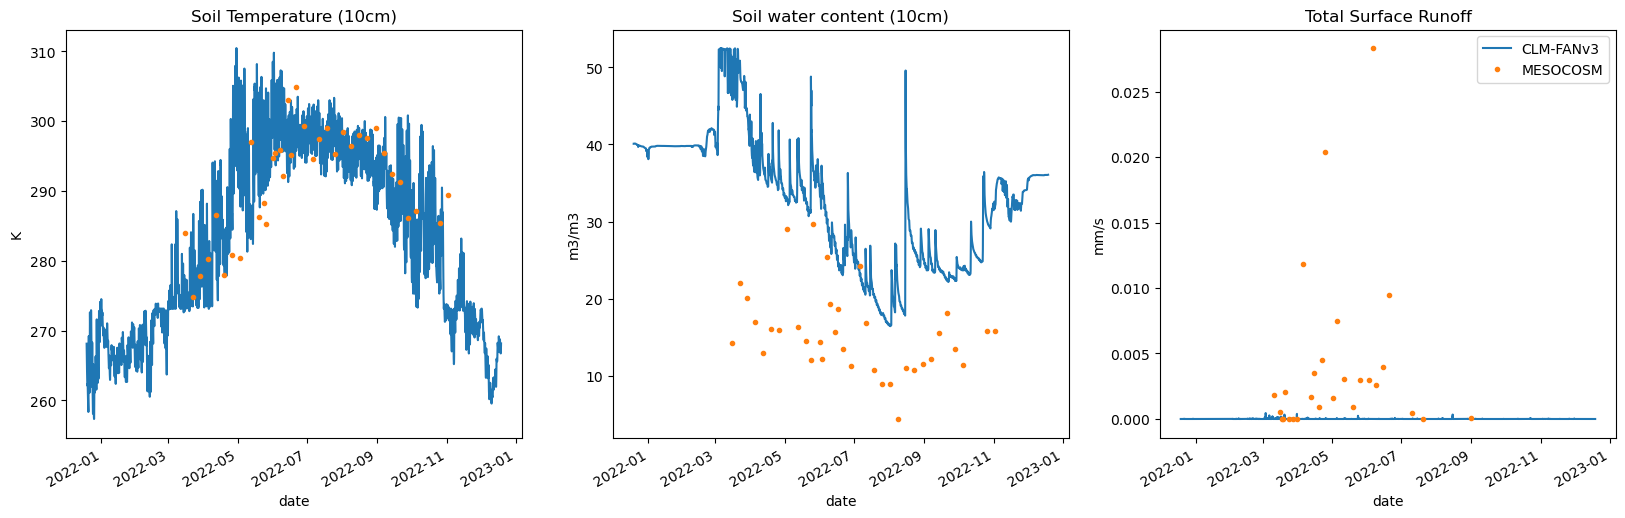

In [40]:
dsSoil = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mesocosm_ghg_flux_data_2022.csv")
dsSoil['date'] = pd.to_datetime(dsSoil['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsSoil['air_temperature_K'] = dsSoil['air_temperature_C'] + 273.15
dsSoil.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsSoil = dsSoil.sort_index()

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
dsCLM_Clarion['TSOI_10CM'].plot(ax=ax[0], label='CLM-FANv3')
dsSoil.loc[('Clarion', 123), 'air_temperature_K'].groupby('date').mean().plot(ax=ax[0], style='.', label='MESOCOSM')
ax[0].set_title("Soil Temperature (10cm)")
ax[0].set_ylabel("K")

b = dsCLM_Clarion['H2OSOI'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')*100
b.plot(ax=ax[1], label='CLM-FANv3')
dsSoil.loc[('Clarion', 123), 'soil_moisture_volume_percent'].groupby('date').mean().plot(ax=ax[1], style='.', label='MESOCOSM')
ax[1].set_title("Soil water content (10cm)")
ax[1].set_ylabel("m3/m3")

dsWater = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mesocosm_drainage_water_quantity_N_2023.csv")
dsWater['date'] = pd.to_datetime(dsWater['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)

#Sampling period starts from the last sampling. 
dsWater['instantaneous_drainage_mm_s'] = dsWater['instantaneous_drainage_cm']*1000/dsWater['st_days']/24/3600
dsWater.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsWater = dsWater.sort_index()

dsCLM_Clarion['QOVER'].plot(ax=ax[2], label='CLM-FANv3')
dsWater.loc[('Clarion', 123), 'instantaneous_drainage_mm_s'].groupby('date').mean().plot(ax=ax[2], style='.', label='MESOCOSM')
ax[2].set_title("Total Surface Runoff")
ax[2].set_ylabel("mm/s")

plt.legend()
fig.savefig("graphs/Env.jpg", dpi=200)
plt.show()

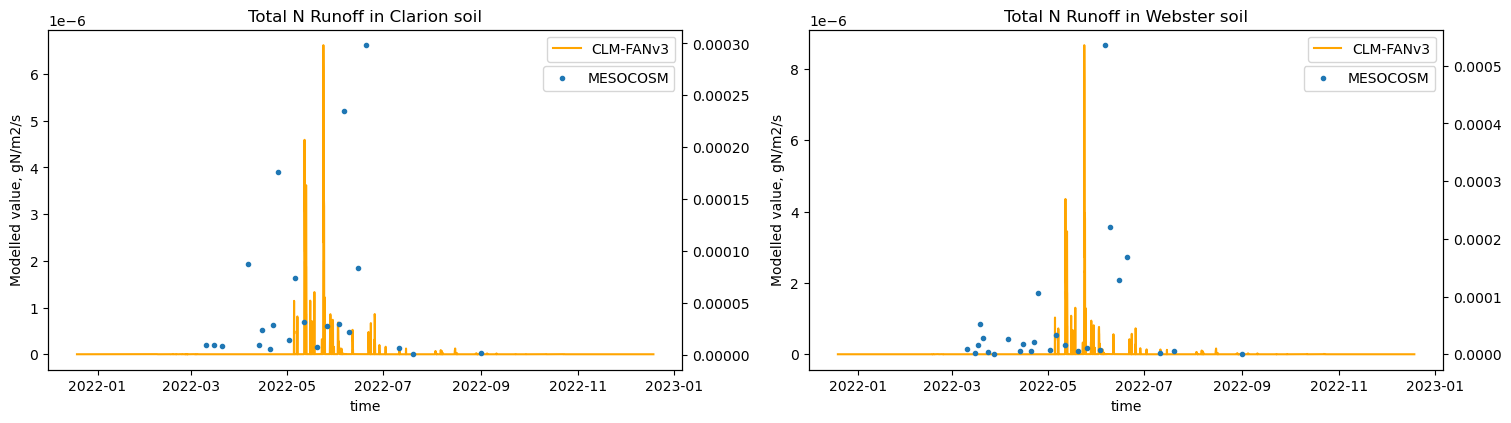

In [41]:
dsWater['instantaneous_drainage_nitrate_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_ammonium_gN_m2_s'] = dsWater['instantaneous_drainage_ammonium_N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_nitrogen_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_gN_m2_s'] + dsWater['instantaneous_drainage_ammonium_gN_m2_s']

fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax2 = ax[0].twinx()
ax3 = ax[1].twinx()
dsCLM_Clarion["Total_N_runoff"] = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
dsCLM_Webster["Total_N_runoff"] = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']

dsCLM_Clarion["Total_N_runoff"].plot(ax=ax[0], label='CLM-FANv3', color='orange')
ax[0].set_ylabel('Modelled value, gN/m2/s')
ax[0].set_title('Total N Runoff in Clarion soil')
dsWater.loc[('Clarion', 123), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean().plot(ax=ax2, style='.', label='MESOCOSM')
dsCLM_Webster["Total_N_runoff"].plot(ax=ax[1], label='CLM-FANv3', color='orange')
dsWater.loc[('Webster', 123), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean().plot(ax=ax3, style='.', label='MESOCOSM')
ax[1].set_ylabel('Modelled value, gN/m2/s')
ax[1].set_title('Total N Runoff in Webster soil')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax[0].legend()
ax2.legend(loc=[0.78, 0.82])
ax[1].legend()
ax3.legend(loc=[0.78, 0.82])
#plt.tight_layout()
fig.savefig("graphs/Runoff_123kg.jpg", dpi=200)
plt.show()

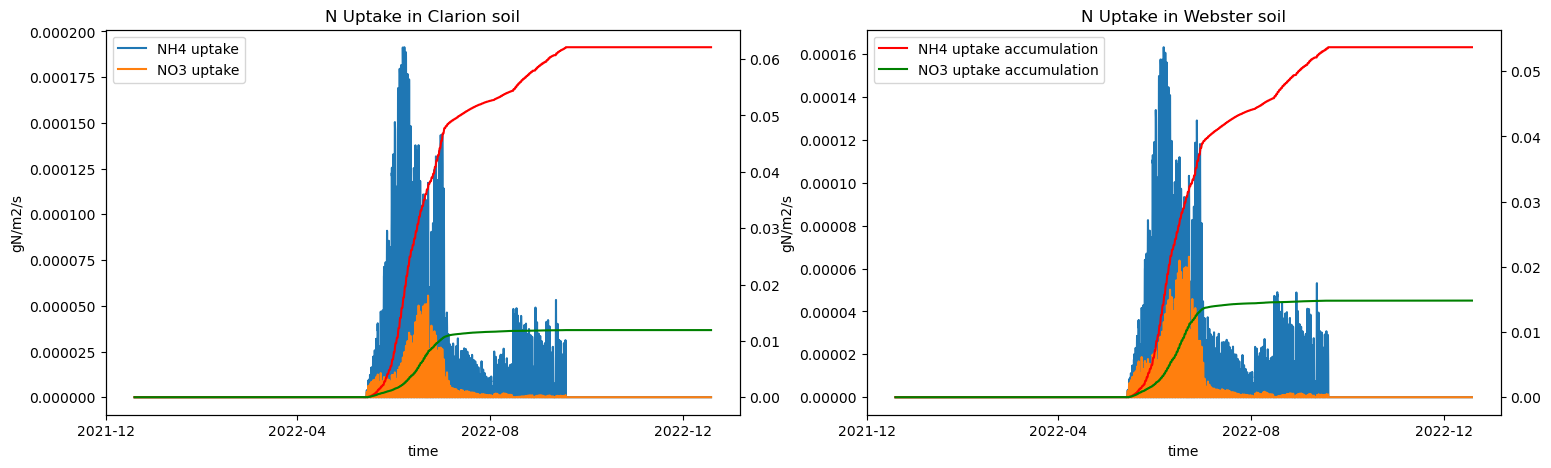

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax2 = ax[0].twinx()
ax3 = ax[1].twinx()
dsCLM_Clarion['time'] = [cftime.num2date(x, "days since 1970-01-01") for x in dsCLM_Clarion.time]
dsCLM_Webster['time'] = [cftime.num2date(x, "days since 1970-01-01") for x in dsCLM_Webster.time]
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[0], label='NH4 uptake')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[0], label='NO3 uptake')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum().plot(ax=ax2, label='NH4 uptake', color='red')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum().plot(ax=ax2, label='NO3 uptake', color='green')
ax[0].set_ylabel('gN/m2/s')
ax[0].set_title('N Uptake in Clarion soil')
ax2.set_ylabel('')
ax[0].legend(loc='upper left')

dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[1], label='NH4 uptake')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[1], label='NO3 uptake')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum().plot(ax=ax3, label='NH4 uptake accumulation', color='red')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum().plot(ax=ax3, label='NO3 uptake accumulation', color='green')
ax[1].set_ylabel('gN/m2/s')
ax[1].set_title('N Uptake in Webster soil')
ax3.set_ylabel('')
plt.legend()
fig.savefig("graphs/Uptake_123kg.jpg", dpi=200)
plt.show()

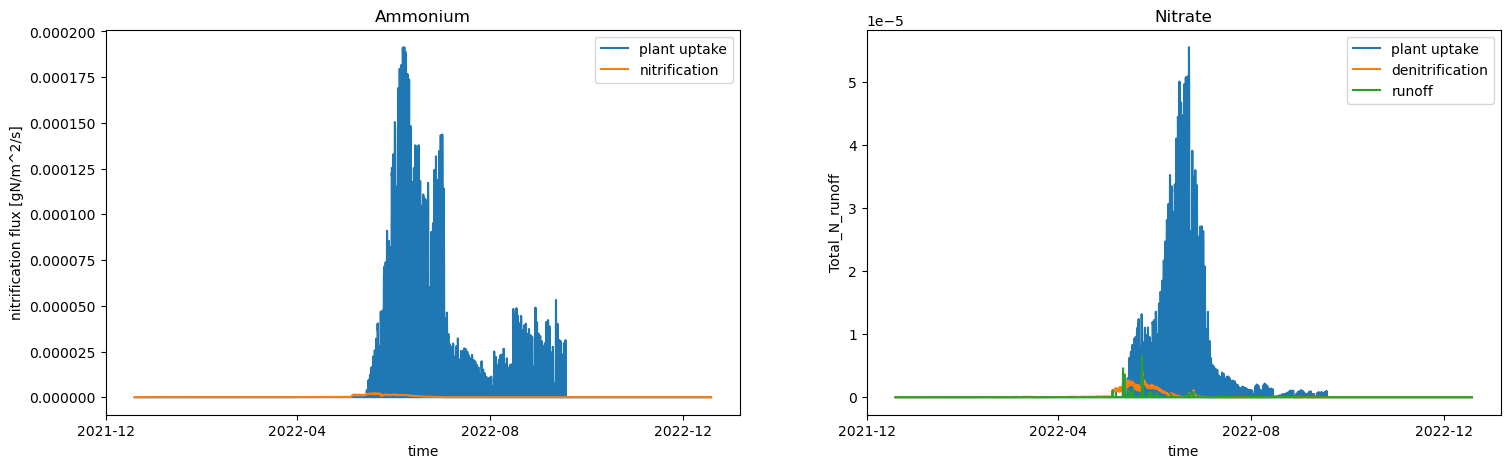

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[0], label='plant uptake')
dsCLM_Clarion['F_NIT'].plot(ax=ax[0], label='nitrification')
ax[0].legend()
ax[0].set_title('Ammonium')

dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[1], label='plant uptake')
dsCLM_Clarion['F_DENIT'].plot(ax=ax[1], label='denitrification')
dsCLM_Clarion["Total_N_runoff"].plot(ax=ax[1], label='runoff')
ax[1].set_title('Nitrate')

plt.legend()
fig.savefig("graphs/N_flows_123kg.jpg", dpi=200)
plt.show()

### 168 kgN fertilizer experiment

In [44]:
fert_amount = "168"

case_clarion = "MESOCOSM_Clarion_" + fert_amount + "kgN"
case_webster = "MESOCOSM_Webster_" + fert_amount + "kgN"
path_clarion = "/glade/scratch/jinmuluo/archive/" + case_clarion + "/lnd/hist/" 
path_webster = "/glade/scratch/jinmuluo/archive/" + case_webster + "/lnd/hist/" 

CLM_Clarion = []
CLM_Webster = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate +"-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate +"-00000.nc")

In [45]:
def preprocess(ds, fields=GAS+Others+RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)

def preprocess(ds, fields=GAS+Others+RUNOFF):
    return(ds[fields])

dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)

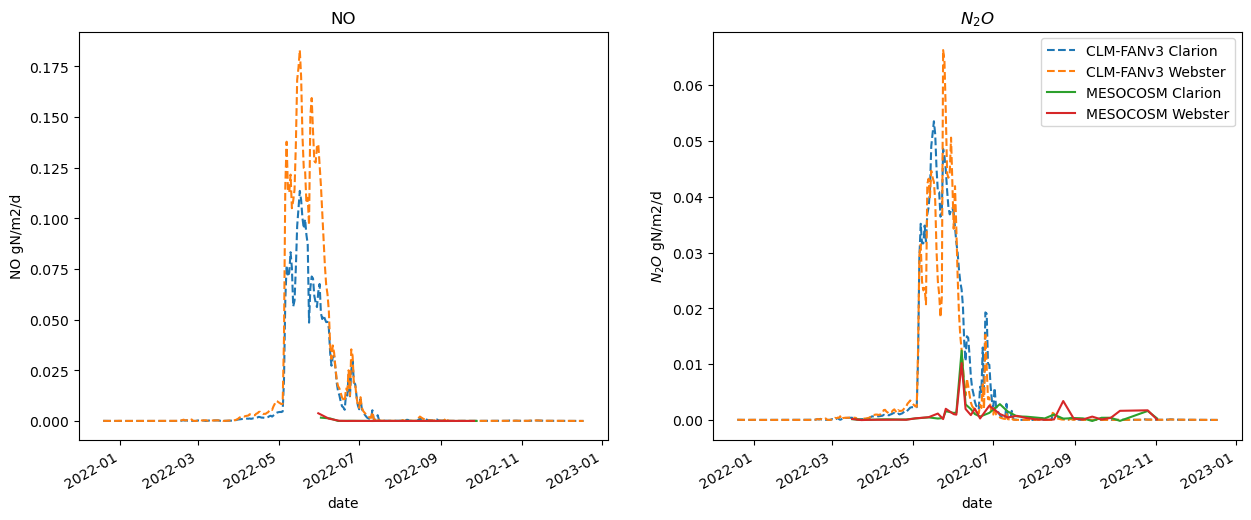

In [46]:
p2 = "/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'mesocosm_ghg_flux_data_2022.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO_Webster.time]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
NO_Clarion.plot(ax=ax[0], ls='--', label='CLM-FANv3 Clarion')
NO_Webster.plot(ax=ax[0], ls='--', label='CLM-FANv3 Webster')
dsNO.loc[('Clarion', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean().plot(ax=ax[0], label='MESOCOSM Clarion')
dsNO.loc[('Webster', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean().plot(ax=ax[0], label='MESOCOSM Webster')


ax[0].set_title("NO")
ax[0].set_ylabel("NO gN/m2/d")

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in N2O_Webster.time]

N2O_Clarion.plot(ax=ax[1], ls='--', label='CLM-FANv3 Clarion')
N2O_Webster.plot(ax=ax[1], ls='--', label='CLM-FANv3 Webster')
dsN2O.loc[('Clarion', 168), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean().plot(ax=ax[1], label='MESOCOSM Clarion')
dsN2O.loc[('Webster', 168), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean().plot(ax=ax[1], label='MESOCOSM Webster')

ax[1].set_title("$N_2O$")
ax[1].set_ylabel("$N_2O$ gN/m2/d")
ax[1].legend()

fig.savefig("graphs/Ngas_168kgN.jpg", dpi=200)
plt.show()

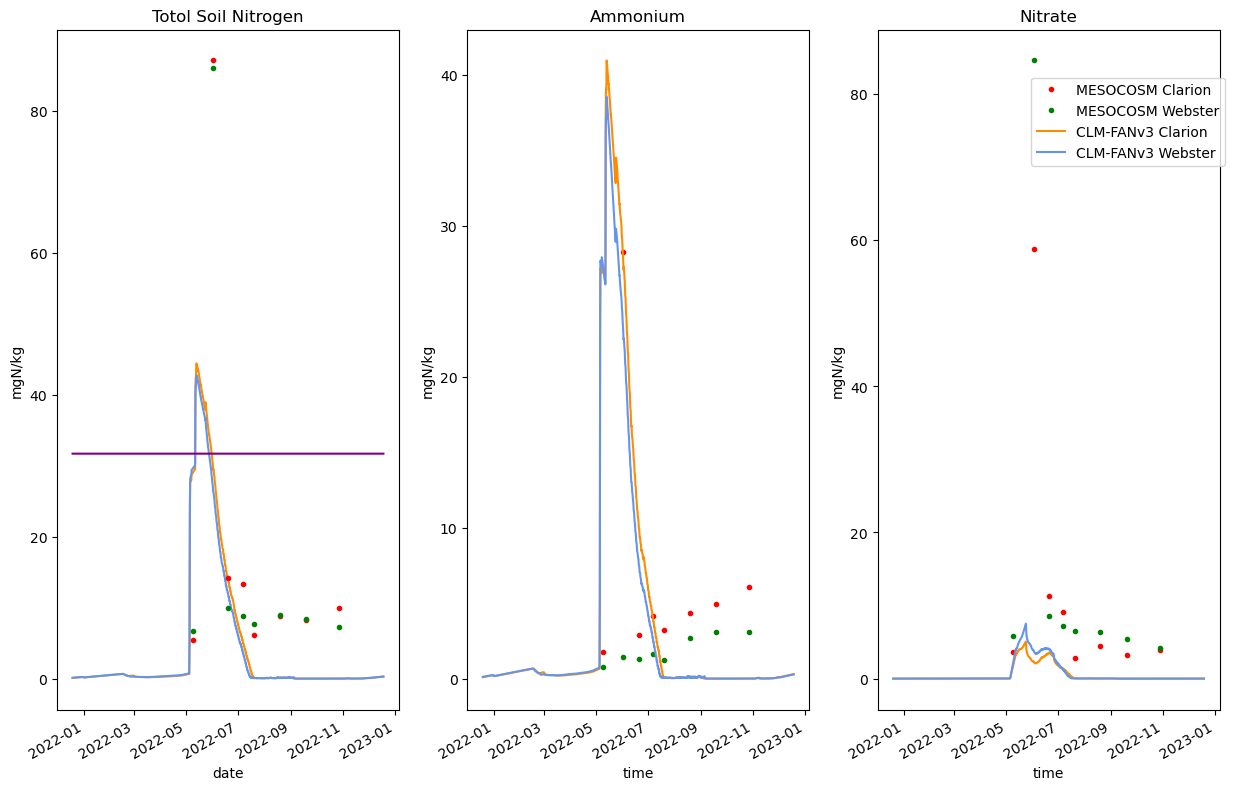

In [47]:
dsMESOCOSM = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mescocosm_extracted_soil_nitrogen_2022.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

dsCLM_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in dsCLM_Clarion.time]
dsCLM_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in dsCLM_Webster.time]

sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
sminn_Clarion = sminn_Clarion*1000/2650
sminn_Webster = sminn_Webster*1000/2650

# gN/m2 to mgN/kg, fertilization depth is around top 20cm
fert_conc = 16.8*1000/0.2/2650

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sminn_Clarion.plot(ax=ax[0], label='CLM-FANv3 Clarion', color='darkorange')
sminn_Webster.plot(ax=ax[0], label='CLM-FANv3 Webster', color='cornflowerblue')
dsMESOCOSM.loc[('Clarion', 168), 'soil_sminn'].groupby(level='date').mean().plot(ax=ax[0], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 168), 'soil_sminn'].groupby(level='date').mean().plot(ax=ax[0], style='.', label='MESOCOSM Webster', color='green')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc, color='purple')
ax[0].set_title("Totol Soil Nitrogen")
ax[0].set_ylabel("mgN/kg")

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
nh4_Clarion = nh4_Clarion*1000/2650
nh4_Webster = nh4_Webster*1000/2650

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
    
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/2650
no3_Webster = no3_Webster*1000/2650

dsMESOCOSM.loc[('Clarion', 168), 'soil_ammonium_mgN_kg'].groupby(level='date').mean().plot(ax=ax[1], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 168), 'soil_ammonium_mgN_kg'].groupby(level='date').mean().plot(ax=ax[1], style='.', label='MESOCOSM Webster', color='green')
nh4_Clarion.plot(ax=ax[1], label='CLM-FANv3 Clarion', color='darkorange')
nh4_Webster.plot(ax=ax[1], label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].set_title("Ammonium")
ax[1].set_ylabel("mgN/kg")

dsMESOCOSM.loc[('Clarion', 168), 'soil_nitrate_mgN_kg'].groupby(level='date').mean().plot(ax=ax[2], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 168), 'soil_nitrate_mgN_kg'].groupby(level='date').mean().plot(ax=ax[2], style='.', label='MESOCOSM Webster', color='green')
no3_Clarion.plot(ax=ax[2], label='CLM-FANv3 Clarion', color='darkorange')
no3_Webster.plot(ax=ax[2], label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].set_title("Nitrate")
ax[2].set_ylabel("mgN/kg")

plt.legend(loc=[0.45, 0.80])
fig.savefig("graphs/Nconc_168kgN.jpg", dpi=200)
plt.show()

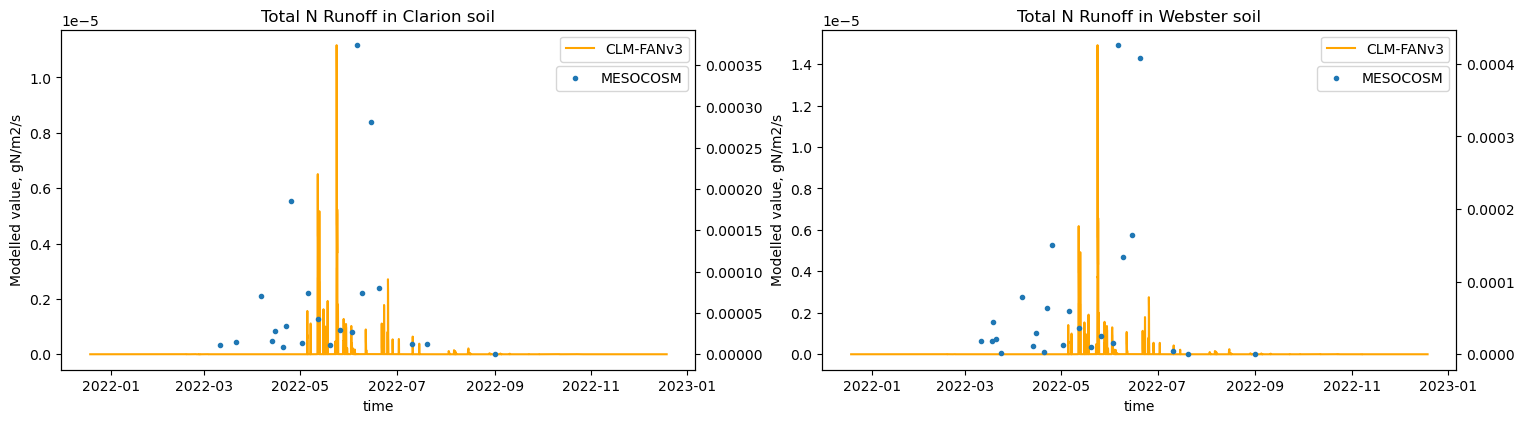

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax2 = ax[0].twinx()
ax3 = ax[1].twinx()
dsCLM_Clarion["Total_N_runoff"] = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
dsCLM_Webster["Total_N_runoff"] = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']

dsCLM_Clarion["Total_N_runoff"].plot(ax=ax[0], label='CLM-FANv3', color='orange')
ax[0].set_ylabel('Modelled value, gN/m2/s')
ax[0].set_title('Total N Runoff in Clarion soil')
dsWater.loc[('Clarion', 168), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean().plot(ax=ax2, style='.', label='MESOCOSM')
dsCLM_Webster["Total_N_runoff"].plot(ax=ax[1], label='CLM-FANv3', color='orange')
dsWater.loc[('Webster', 168), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean().plot(ax=ax3, style='.', label='MESOCOSM')
ax[1].set_ylabel('Modelled value, gN/m2/s')
ax[1].set_title('Total N Runoff in Webster soil')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax[0].legend()
ax2.legend(loc=[0.78, 0.82])
ax[1].legend()
ax3.legend(loc=[0.78, 0.82])
#plt.tight_layout()
fig.savefig("graphs/Runoff_168kg.jpg", dpi=200)
plt.show()

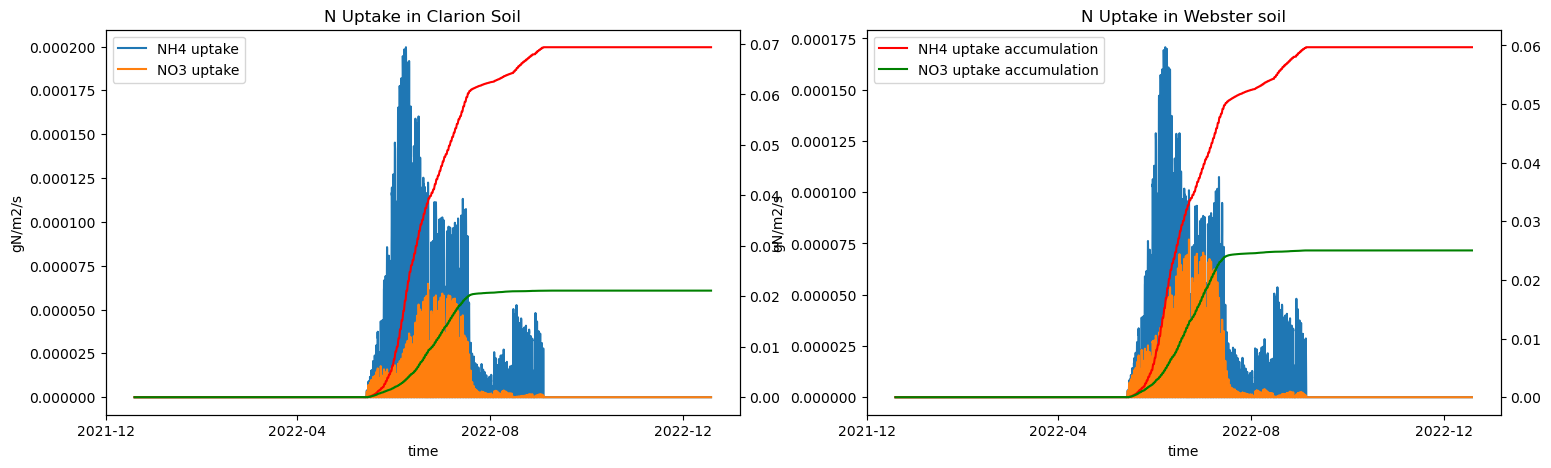

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax2 = ax[0].twinx()
ax3 = ax[1].twinx()
dsCLM_Clarion['time'] = [cftime.num2date(x, "days since 1970-01-01") for x in dsCLM_Clarion.time]
dsCLM_Webster['time'] = [cftime.num2date(x, "days since 1970-01-01") for x in dsCLM_Webster.time]
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[0], label='NH4 uptake')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[0], label='NO3 uptake')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum().plot(ax=ax2, label='NH4 uptake', color='red')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum().plot(ax=ax2, label='NO3 uptake', color='green')
ax[0].set_ylabel('gN/m2/s')
ax[0].set_title('N Uptake in Clarion Soil')
ax[0].legend(loc='upper left')
ax2.set_ylabel('')

dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[1], label='NH4 uptake')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[1], label='NO3 uptake')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum().plot(ax=ax3, label='NH4 uptake accumulation', color='red')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum().plot(ax=ax3, label='NO3 uptake accumulation', color='green')
ax[1].set_ylabel('gN/m2/s')
ax[1].set_title('N Uptake in Webster soil')
ax3.set_ylabel('')
plt.legend()
fig.savefig("graphs/Uptake_168kg.jpg", dpi=200)
plt.show()

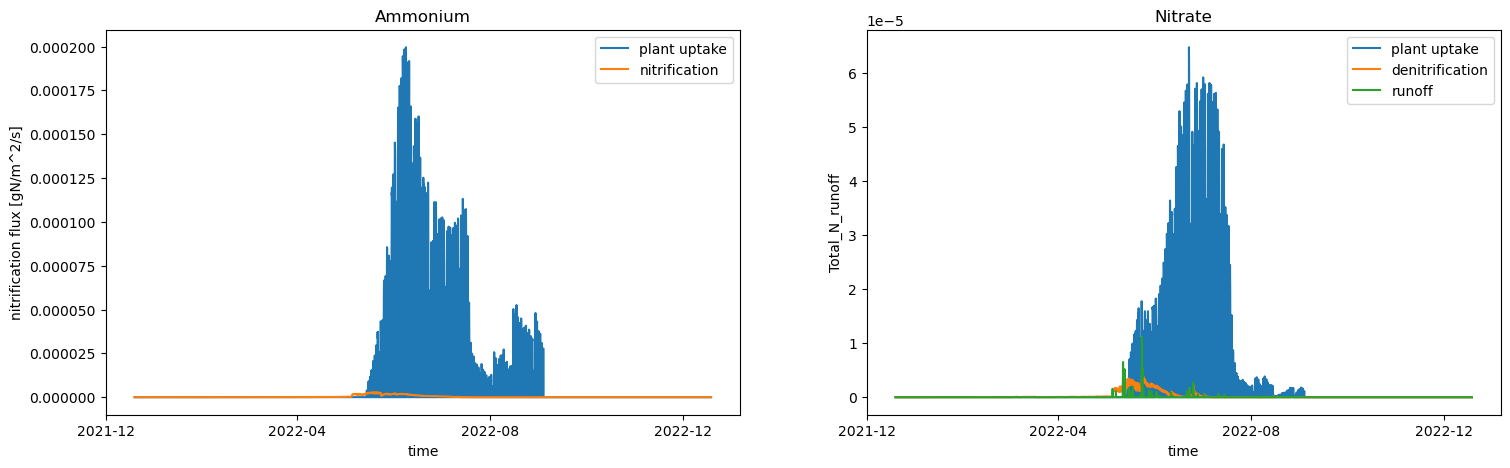

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[0], label='plant uptake')
dsCLM_Clarion['F_NIT'].plot(ax=ax[0], label='nitrification')
ax[0].legend()
ax[0].set_title('Ammonium')

dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[1], label='plant uptake')
dsCLM_Clarion['F_DENIT'].plot(ax=ax[1], label='denitrification')
dsCLM_Clarion["Total_N_runoff"].plot(ax=ax[1], label='runoff')
ax[1].set_title('Nitrate')

plt.legend()
fig.savefig("graphs/N_flows_168kg.jpg", dpi=200)
plt.show()

### 213 kgN fertilizer experiment

In [51]:
fert_amount = "213"

case_clarion = "MESOCOSM_Clarion_" + fert_amount + "kgN"
case_webster = "MESOCOSM_Webster_" + fert_amount + "kgN"
path_clarion = "/glade/scratch/jinmuluo/archive/" + case_clarion + "/lnd/hist/" 
path_webster = "/glade/scratch/jinmuluo/archive/" + case_webster + "/lnd/hist/" 

CLM_Clarion = []
CLM_Webster = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate +"-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate +"-00000.nc")

In [52]:
def preprocess(ds, fields=GAS+Others+RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)

def preprocess(ds, fields=GAS+Others+RUNOFF):
    return(ds[fields])

dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)

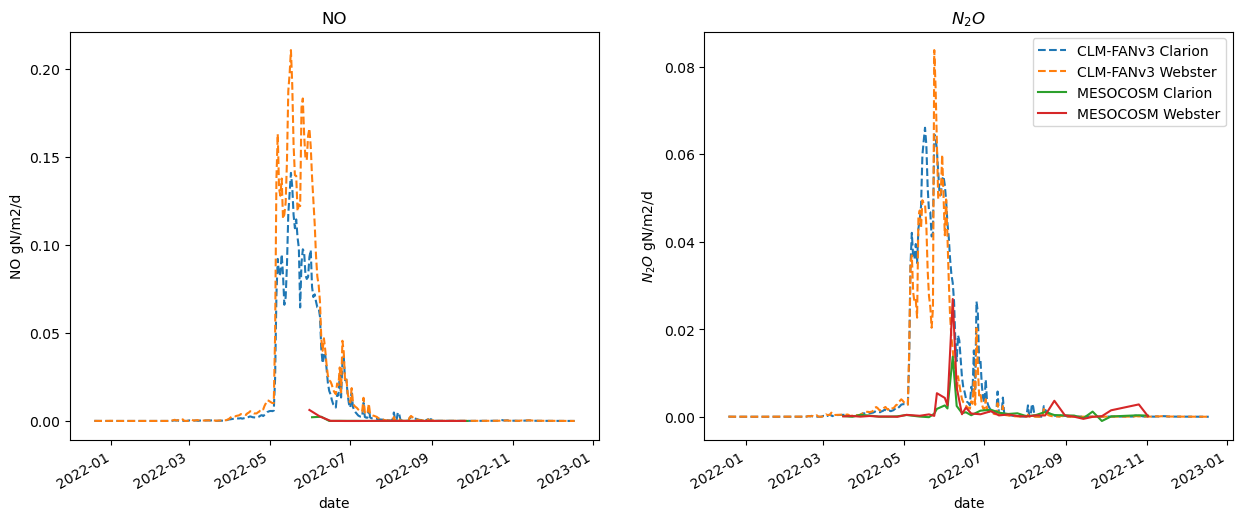

In [53]:
p2 = "/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'mesocosm_ghg_flux_data_2022.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO_Webster.time]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
NO_Clarion.plot(ax=ax[0], ls='--', label='CLM-FANv3 Clarion')
NO_Webster.plot(ax=ax[0], ls='--', label='CLM-FANv3 Webster')
dsNO.loc[('Clarion', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean().plot(ax=ax[0], label='MESOCOSM Clarion')
dsNO.loc[('Webster', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean().plot(ax=ax[0], label='MESOCOSM Webster')
ax[0].set_title("NO")
ax[0].set_ylabel("NO gN/m2/d")

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in N2O_Webster.time]

N2O_Clarion.plot(ax=ax[1], ls='--', label='CLM-FANv3 Clarion')
N2O_Webster.plot(ax=ax[1], ls='--', label='CLM-FANv3 Webster')
dsN2O.loc[('Clarion', 213), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean().plot(ax=ax[1], label='MESOCOSM Clarion')
dsN2O.loc[('Webster', 213), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean().plot(ax=ax[1], label='MESOCOSM Webster')

ax[1].set_title("$N_2O$")
ax[1].set_ylabel("$N_2O$ gN/m2/d")
ax[1].legend()

fig.savefig("graphs/Ngas_213kgN.jpg", dpi=200)
plt.show()

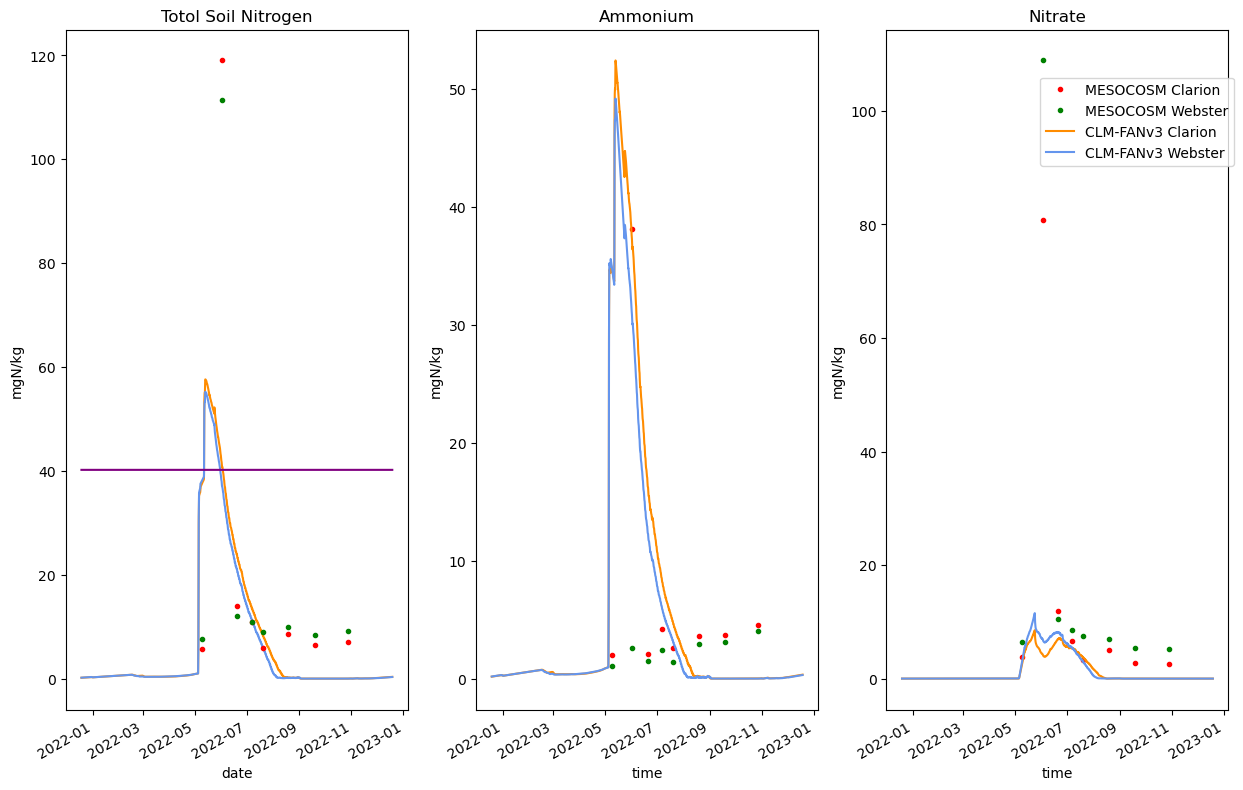

In [54]:
dsMESOCOSM = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mescocosm_extracted_soil_nitrogen_2022.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

dsCLM_Clarion['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in dsCLM_Clarion.time]
dsCLM_Webster['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in dsCLM_Webster.time]

sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
sminn_Clarion = sminn_Clarion*1000/2650
sminn_Webster = sminn_Webster*1000/2650

# gN/m2 to mgN/kg, fertilization depth is around top 20cm
fert_conc = 21.3*1000/0.2/2650

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sminn_Clarion.plot(ax=ax[0], label='CLM-FANv3 Clarion', color='darkorange')
sminn_Webster.plot(ax=ax[0], label='CLM-FANv3 Webster', color='cornflowerblue')
dsMESOCOSM.loc[('Clarion', 212), 'soil_sminn'].groupby(level='date').mean().plot(ax=ax[0], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 212), 'soil_sminn'].groupby(level='date').mean().plot(ax=ax[0], style='.', label='MESOCOSM Webster', color='green')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc, color='purple')
ax[0].set_title("Totol Soil Nitrogen")
ax[0].set_ylabel("mgN/kg")

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
nh4_Clarion = nh4_Clarion*1000/2650
nh4_Webster = nh4_Webster*1000/2650

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
    
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/2650
no3_Webster = no3_Webster*1000/2650

dsMESOCOSM.loc[('Clarion', 212), 'soil_ammonium_mgN_kg'].groupby(level='date').mean().plot(ax=ax[1], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 212), 'soil_ammonium_mgN_kg'].groupby(level='date').mean().plot(ax=ax[1], style='.', label='MESOCOSM Webster', color='green')
nh4_Clarion.plot(ax=ax[1], label='CLM-FANv3 Clarion', color='darkorange')
nh4_Webster.plot(ax=ax[1], label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].set_title("Ammonium")
ax[1].set_ylabel("mgN/kg")

dsMESOCOSM.loc[('Clarion', 212), 'soil_nitrate_mgN_kg'].groupby(level='date').mean().plot(ax=ax[2], style='.', label='MESOCOSM Clarion', color='red')
dsMESOCOSM.loc[('Webster', 212), 'soil_nitrate_mgN_kg'].groupby(level='date').mean().plot(ax=ax[2], style='.', label='MESOCOSM Webster', color='green')
no3_Clarion.plot(ax=ax[2], label='CLM-FANv3 Clarion', color='darkorange')
no3_Webster.plot(ax=ax[2], label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].set_title("Nitrate")
ax[2].set_ylabel("mgN/kg")

plt.legend(loc=[0.45, 0.80])
fig.savefig("graphs/Nconc_213kgN.jpg", dpi=200)
plt.show()

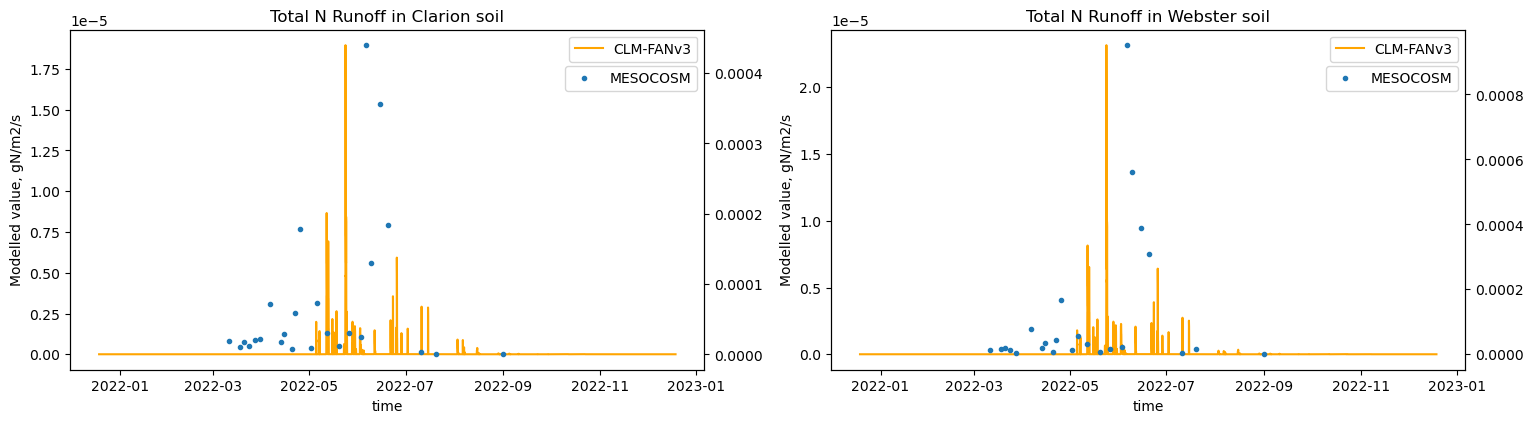

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax2 = ax[0].twinx()
ax3 = ax[1].twinx()
dsCLM_Clarion["Total_N_runoff"] = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
dsCLM_Webster["Total_N_runoff"] = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']

dsCLM_Clarion["Total_N_runoff"].plot(ax=ax[0], label='CLM-FANv3', color='orange')
ax[0].set_ylabel('Modelled value, gN/m2/s')
ax[0].set_title('Total N Runoff in Clarion soil')
dsWater.loc[('Clarion', 213), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean().plot(ax=ax2, style='.', label='MESOCOSM')
dsCLM_Webster["Total_N_runoff"].plot(ax=ax[1], label='CLM-FANv3', color='orange')
dsWater.loc[('Webster', 213), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean().plot(ax=ax3, style='.', label='MESOCOSM')
ax[1].set_ylabel('Modelled value, gN/m2/s')
ax[1].set_title('Total N Runoff in Webster soil')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax[0].legend()
ax2.legend(loc=[0.78, 0.82])
ax[1].legend()
ax3.legend(loc=[0.78, 0.82])
#plt.tight_layout()
fig.savefig("graphs/Runoff_213kg.jpg", dpi=200)
plt.show()

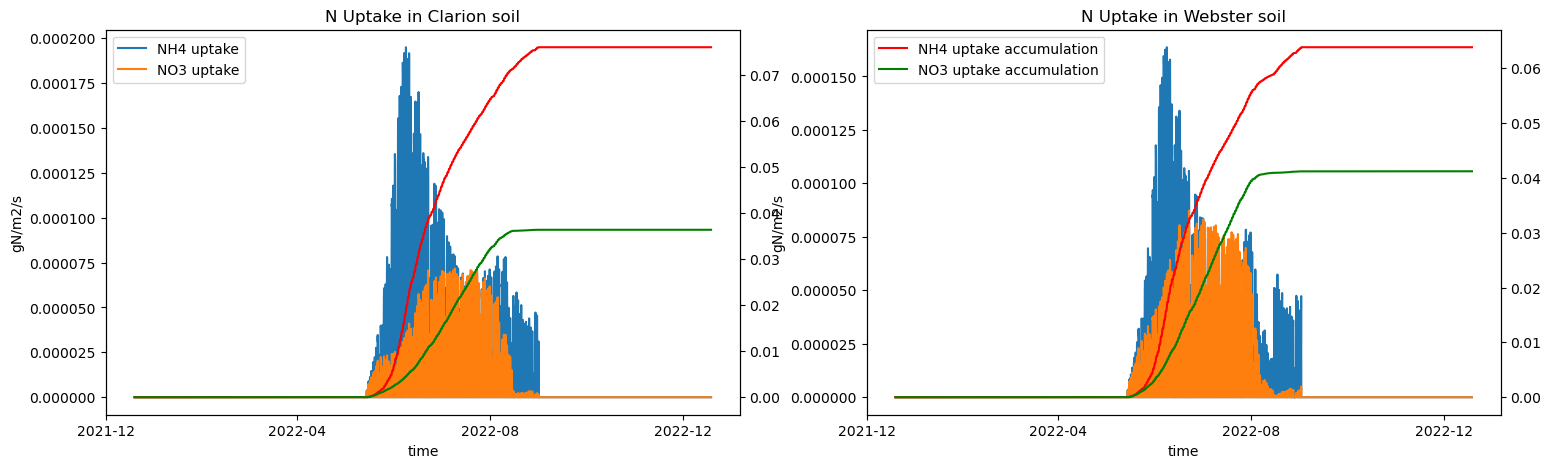

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax2 = ax[0].twinx()
ax3 = ax[1].twinx()
dsCLM_Clarion['time'] = [cftime.num2date(x, "days since 1970-01-01") for x in dsCLM_Clarion.time]
dsCLM_Webster['time'] = [cftime.num2date(x, "days since 1970-01-01") for x in dsCLM_Webster.time]
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[0], label='NH4 uptake')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[0], label='NO3 uptake')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum().plot(ax=ax2, label='NH4 uptake', color='red')
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum().plot(ax=ax2, label='NO3 uptake', color='green')
ax[0].set_ylabel('gN/m2/s')
ax[0].legend(loc='upper left')
ax[0].set_title('N Uptake in Clarion soil')
ax2.set_ylabel('')

dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[1], label='NH4 uptake')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[1], label='NO3 uptake') 
dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum().plot(ax=ax3, label='NH4 uptake accumulation', color='red')
dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum().plot(ax=ax3, label='NO3 uptake accumulation', color='green')
ax[1].set_ylabel('gN/m2/s')
ax[1].set_title('N Uptake in Webster soil')
ax3.set_ylabel('')
plt.legend()
fig.savefig("graphs/Uptake_213kg.jpg", dpi=200)
plt.show()

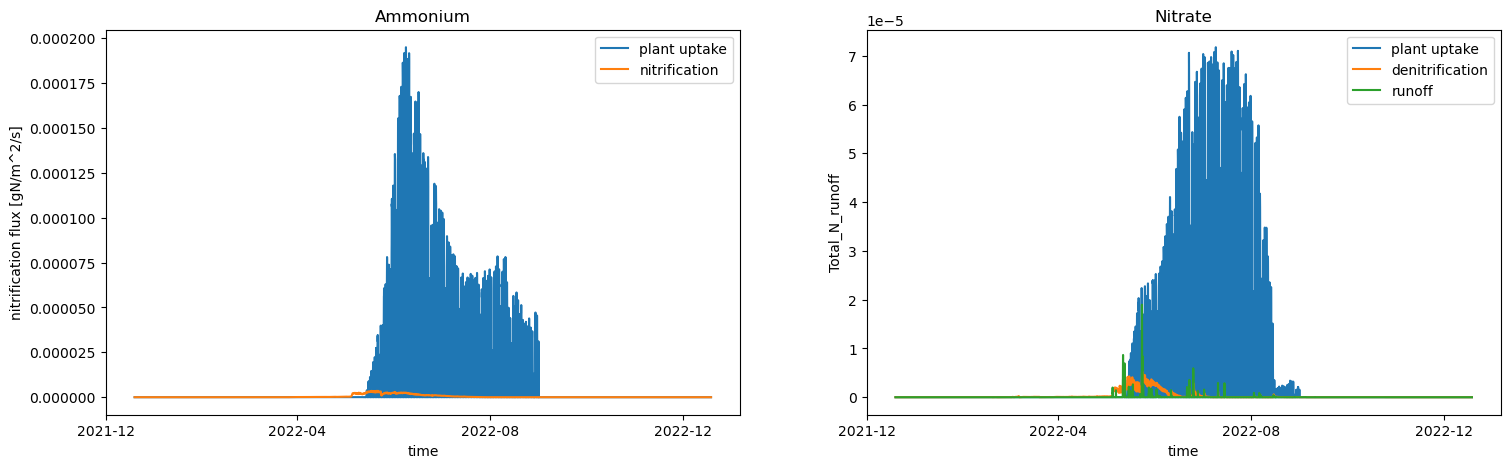

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').plot(ax=ax[0], label='plant uptake')
dsCLM_Clarion['F_NIT'].plot(ax=ax[0], label='nitrification')
ax[0].legend()
ax[0].set_title('Ammonium')

dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').plot(ax=ax[1], label='plant uptake')
dsCLM_Clarion['F_DENIT'].plot(ax=ax[1], label='denitrification')
dsCLM_Clarion["Total_N_runoff"].plot(ax=ax[1], label='runoff')
ax[1].set_title('Nitrate')
plt.legend()
fig.savefig("graphs/N_flows_213kg.jpg", dpi=200)
plt.show()